In [1]:
import tensorflow as tf
import os
import sys
import go_datafile_reader
import model
import numpy as np
import model_eval

In [2]:
train_dir = "../data/input/train"
test_dir = "../data/input/test"
ckpt_path = "../data/working/cnn_5layer_64filter"

In [3]:
train_files = []
for subdir, dirs, files in os.walk(train_dir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".dat"):
            train_files.append(filepath)

test_files = []
for subdir, dirs, files in os.walk(test_dir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".dat"):
            test_files.append(filepath)

print "num train: %d, num test: %d" %(len(train_files), len(test_files))

num train: 498, num test: 54


In [4]:
#note you may have to change the os limit for number of open files to use the RandomAccessFileReader
#you can do this with the command "sudo ulimit -n 20000"
#if sudo can't find the ulimit command try the following below
#sudo sh -c "ulimit -n 20000 && exec su $LOGNAME"

reader = go_datafile_reader.RandomAccessFileReader(train_files, board_size=9)
test_reader = go_datafile_reader.GoDatafileReader(test_files, board_size=9)

test_reader.num_epochs = 0
test_features = []
test_targets = []
test_move_numbers = []
while(test_reader.num_epochs == 0):
    test_move_numbers.append(test_reader.move_index)
    final_state, _, feature_cube = test_reader.read_sample()
    test_features.append(feature_cube)
    test_targets.append(final_state)

Initializing pointers in 498 datafiles, this may take a few minutes


In [5]:
x, ownership = model.place_holders(board_size=9)
y_conv = model.model(x, board_size=9)
loss = model.loss_function(ownership, y_conv)
train_op = model.train_step(loss)

prediction = tf.round(y_conv)
correct_prediction = tf.equal(ownership, prediction)
correct_count = tf.reduce_sum(tf.cast(correct_prediction, "float"))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

ckpt_dir, _ = os.path.split(ckpt_path)
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt is not None:
    print("restore from previous checkpoint")
    saver.restore(sess, ckpt)

restore from previous checkpoint
INFO:tensorflow:Restoring parameters from ../data/working/cnn_5layer_64filter


In [6]:
best_test_accuracy = 0
training_accuracies = []
test_accuracies = []
for k in range(2500):
    x_batch, y_batch = reader.get_batch(50)
    _, loss_value, y_value = sess.run([train_op, loss, y_conv], feed_dict={x:x_batch, ownership:y_batch})
    if k % 10 == 0:
        acc = accuracy.eval(feed_dict={x:x_batch, ownership:y_batch})
        training_accuracies.append(acc)
        print('step=%d, loss=%f, acc=%f' % (k, loss_value, acc))
            
    if k % 1000 == 0:
        test_accuracy = model_eval.test_accuracy(test_features, test_targets, x, ownership, correct_count, board_size=9)
        test_accuracies.append(test_accuracy)
        print("Test accuracy: %f" % test_accuracy)
        if test_accuracy > best_test_accuracy:
            print("New best test accuracy, saving checkpoint...")
            saver.save(sess, ckpt_path)
            best_test_accuracy = test_accuracy
        else:
            print('test accuracy %s less than %s, no progress...' % (
                test_accuracy, best_test_accuracy))

step=0, loss=0.103982, acc=0.856790
Test accuracy: 0.834852
Saving Checkpoint...
step=10, loss=0.101945, acc=0.859506
step=20, loss=0.102445, acc=0.863210
step=30, loss=0.104539, acc=0.853333
step=40, loss=0.099745, acc=0.865185
step=50, loss=0.116503, acc=0.837037
step=60, loss=0.101140, acc=0.863210
step=70, loss=0.106569, acc=0.850370
step=80, loss=0.085043, acc=0.886420
step=90, loss=0.121852, acc=0.828642
step=100, loss=0.102194, acc=0.853333
step=110, loss=0.117685, acc=0.834568
step=120, loss=0.094368, acc=0.871111
step=130, loss=0.111247, acc=0.849383
step=140, loss=0.082840, acc=0.888642
step=150, loss=0.141996, acc=0.798272
step=160, loss=0.098977, acc=0.865926
step=170, loss=0.066498, acc=0.916790
step=180, loss=0.104346, acc=0.853333
step=190, loss=0.112968, acc=0.837531
step=200, loss=0.104168, acc=0.864444
step=210, loss=0.132831, acc=0.803951
step=220, loss=0.101676, acc=0.855062
step=230, loss=0.094071, acc=0.867901
step=240, loss=0.089822, acc=0.874568
step=250, loss=0

step=2100, loss=0.080565, acc=0.878765
step=2110, loss=0.058438, acc=0.923457
step=2120, loss=0.081410, acc=0.890370
step=2130, loss=0.082925, acc=0.885432
step=2140, loss=0.074891, acc=0.901235
step=2150, loss=0.093941, acc=0.860494
step=2160, loss=0.075371, acc=0.897531
step=2170, loss=0.079277, acc=0.882469
step=2180, loss=0.082039, acc=0.880741
step=2190, loss=0.067985, acc=0.910617
step=2200, loss=0.064710, acc=0.916543
step=2210, loss=0.065744, acc=0.907161
step=2220, loss=0.093132, acc=0.872593
step=2230, loss=0.074656, acc=0.900000
step=2240, loss=0.056948, acc=0.928889
step=2250, loss=0.077617, acc=0.885926
step=2260, loss=0.084246, acc=0.892346
step=2270, loss=0.081369, acc=0.886173
step=2280, loss=0.075004, acc=0.899012
step=2290, loss=0.067374, acc=0.900741
step=2300, loss=0.069006, acc=0.907901
step=2310, loss=0.062412, acc=0.926173
step=2320, loss=0.074503, acc=0.901235
step=2330, loss=0.082469, acc=0.888395
step=2340, loss=0.064589, acc=0.915309
step=2350, loss=0.088210,

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def rolling_mean(number_list, window = 20):
    means = np.zeros(len(number_list))
    for i in xrange(len(means)):
        sub_window = number_list[i-window+1:i+1]
        means[i] = np.mean(sub_window)
    return means

250


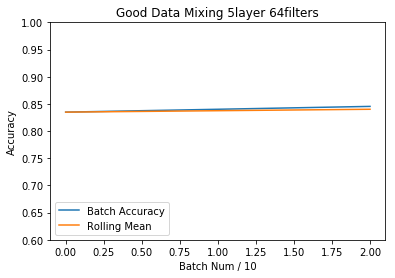

In [9]:
print len(training_accuracies)
means = rolling_mean(test_accuracies, 20)
plt.plot(test_accuracies, label="Batch Accuracy")
plt.plot(means, label= "Rolling Mean")
plt.title("Good Data Mixing 5layer 64filters")
plt.xlabel("Batch Num / 10")
plt.ylabel("Accuracy")
plt.ylim([0.6,1])
plt.legend(loc=3)
plt.show()

In [10]:
accuracies = []
y_trues = []
y_preds = []
y_vals = []
feature_cubes = []
for i in xrange(len(test_features)):
    if i%500 == 0:
        print i
    x_, y_ = test_features[i], test_targets[i]
    y_val, y_pred, acc = sess.run([y_conv, prediction, accuracy], feed_dict={x:[x_], ownership:[y_]})
    accuracies.append(acc)
    y_trues.append(np.reshape(y_, [9,9]))
    y_preds.append(np.reshape(y_pred[0], [9,9]))
    y_vals.append(np.reshape(y_val[0], [9,9]))
    feature_cubes.append(x_)

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [11]:
idx = 234
y_pred = y_preds[idx]
y_val = y_vals[idx]
y_true = y_trues[idx]
feature_cube = feature_cubes[idx]

print(test_move_numbers[idx], accuracies[idx])
model_eval.print_info(feature_cube, y_pred, y_val, y_true, board_size=9)

(48, 0.8888889)
*********   000000000   112122100   000000000   .........
*****0***   000001000   231136121   000000000   .....X...
00000110*   000001000   301138300   000000000   .....X...
01101000*   111111001   999999509   011010000   X..X.X..X
1**111010   111111111   999999999   111111010   ......X.X
**1*1011*   111111111   999999999   111111110   ........X
*1011001*   111111111   999999999   111111111   .........
*1000001*   111111111   999999999   111111111   .........
**11*101*   111111111   999999999   111111111   .........


9

In [12]:
import pandas as pd

In [13]:
df = pd.DataFrame()
df["Move Num"] = test_move_numbers
df["Accuracy"] = accuracies
grouped = df.groupby("Move Num").aggregate(np.mean)


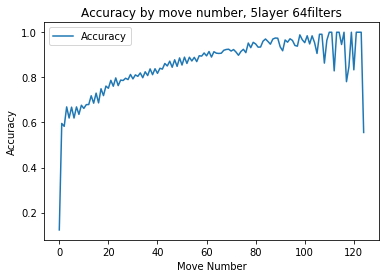

In [14]:
grouped.plot()
plt.title("Accuracy by move number, 5layer 64filters")
plt.xlabel("Move Number")
plt.ylabel("Accuracy")
plt.show()

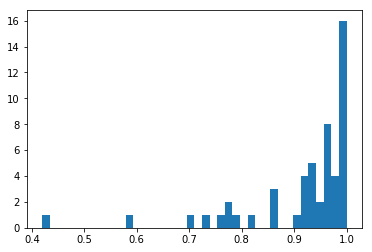

In [15]:
plot = plt.hist(df[df["Move Num"] == 70]["Accuracy"].values, bins = 40)
plt.show()